**Các thay đổi chính:**
- Áp dụng kiến trúc VGG16

**Kết quả**
- Mô hình đạt độ chính xác > 90% đối với dữ liệu lấy từ Test của Fruits360.
- Mô hình có dấu hiệu Over Fitting khi nhầm lẫn trong việc phân loại ảnh trái cây không có trong Fruits360.
- Thời gian huấn luyện mô hình rất lâu (Hơn 3 tiếng)

Liên kết đến Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import thư viện, train và valid

In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16   # Áp dụng kiến trúc VGG16 của CNN

### Tải và pre-handle VGG16 model

Tải mô hình VGG16 pre-trained

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Đóng băng các lớp của VGG16

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

### Xây dựng hàm huấn luyện mô hình CNN



Parameters:

    - train_dir: Đường dẫn đến thư mục Training (chứa các thư mục con như Apple 6, Apple 12, ...)
    - test_dir: Đường dẫn đến thư mục Test
    - num_nodes: Số nơ-ron trong lớp Dense
    - dropout_prob: Xác suất dropout để giảm overfitting
    - lr: Tỷ lệ học (learning rate)
    - batch_size: Kích thước batch
    - epochs: Số epoch huấn luyện

Returns:

    - nn_model: Mô hình đã huấn luyện
    - history: Lịch sử huấn luyện



In [ ]:
def train_cnn_model(train_dir, test_dir, num_nodes, dropout_prob, lr, batch_size, epochs, shuffle=True):

  #1. Tạo ImageDataGenerator để tải và tiền xử lý dữ liệu ảnh
  train_datagen = ImageDataGenerator(
      rescale=1./255,           # Chuẩn hóa giá trị pixel về [0, 1]
      rotation_range=10,        # Data augmentation: xoay ngẫu nhiên
      width_shift_range=0.1,    # Dịch ngang
      height_shift_range=0.1,   # Dịch dọc
      shear_range=0.1,          # Tạo ra một biến dạng trong đó các pixel bị kéo hoặc nghiêng theo một góc (được đo bằng độ hoặc tỷ lệ), tối đa 20%
      zoom_range=0.1,           # Phóng to
      horizontal_flip=True,     # Lật ngang ảnh ngẫu nhiên
      fill_mode='nearest'       # Xác định cách điền các pixel mới khi ảnh bị biến đổi (xoay, dịch, zoom, v.v.)
  )

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(224, 224),   # Resize ảnh về 224x224 để sử dụng VGG16
      batch_size=batch_size,
      class_mode='categorical',  # Phân loại đa lớp
      shuffle=shuffle
  )

  test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='categorical'
  )

  # 2. Xây dựng mô hình CNN
  cnn_model = tf.keras.Sequential([
      base_model,

      # Lớp Flatten để chuyển đổi đặc trưng thành vector 1 chiều
      Flatten(),

      # Lớp Dense để phân loại
      Dense(
          num_nodes,
          activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),   # Phạt các trọng số lớn
      BatchNormalization(),
      Dropout(dropout_prob),
      Dense(
          num_nodes,
          activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),   # Phạt các trọng số lớn
      BatchNormalization(),
      Dropout(dropout_prob),

      # Lớp đầu ra cho n lớp của dữ liệu được huấn luyện
      Dense(train_generator.num_classes, activation='softmax')
  ])

  # 3. Biên dịch mô hình
  cnn_model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  # 4. Tính class weights (Xử lý trường hợp dữ liệu chênh lệch số lượng)
  class_labels = np.unique(train_generator.classes)
  class_weights = compute_class_weight(
        class_weight='balanced',
        classes=class_labels,
        y=train_generator.classes
  )
  class_weights_dict = dict(enumerate(class_weights))

  # 5. Thiết lập checkpoint để lưu mô hình
  checkpoint = ModelCheckpoint(
      '/content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_{epoch:02d}.h5',
      save_best_only=False,     # Lưu sau mỗi epoch
      save_weights_only=False,  # Lưu toàn bộ mô hình
      verbose=1
  )

  # 6. Thiết lập Early Stopping dừng training khi mô hình không cải thiện
  early_stopping = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True
  )

  reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
  )

  # 7. Huấn luyện mô hình
  history = cnn_model.fit(
      train_generator,
      validation_data=test_generator,
      epochs=epochs,
      verbose=1,                # In thông tin huấn luyện
      callbacks=[checkpoint, early_stopping, reduce_lr],  # Checkpoints & early stopping
      class_weight=class_weights_dict
  )

  return cnn_model, history

### Tiến hành huấn luyện mô hình

Đường dẫn đến thư mục dữ liệu huấn luyện & test

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 19.03.2025/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 19.03.2025/Test'

Huấn luyện mô hình

In [ ]:
model, history = train_cnn_model(
    train_dir=train_dir,
    test_dir=test_dir,
    num_nodes=128,
    dropout_prob=0.5,
    lr=0.0001,
    batch_size=32,
    epochs=50,
    shuffle=True
)

### Kiểm tra kết quả

1. Tải model .h5 trên Drive

In [ ]:
# Kiểm tra các file trong thư mục Checkpoints
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/'
print("Các file trong thư mục Checkpoints:")
for file in os.listdir(checkpoint_dir):
    print(file)

# Tải mô hình từ file .h5 (chọn file từ epoch 23 vì nó là mới nhất)
model_path = os.path.join(checkpoint_dir, 'model_epoch_23.h5')
model = load_model(model_path)
print("Mô hình đã được tải thành công!")

Các file trong thư mục Checkpoints:
model_epoch_21.h5
model_epoch_22.h5
model_epoch_23.h5


Mô hình đã được tải thành công!


2. Huấn luyện lại (nếu đã dừng kernel làm mất history)

3. Biểu đồ thể hiện tỉ lệ chính xác và mất mát

In [ ]:
# Vẽ biểu đồ accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

4. Đánh giá tổng thể trên toàn bộ tập test

In [ ]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 266s 17s/step - accuracy: 1.0000 - loss: 2.1019
Test accuracy: 100.00%
Test loss: 2.1009


Lấy danh sách class names đúng theo mô hình

In [ ]:
# Tải dữ liệu để kiểm tra thứ tự nhãn
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 19.03.2025/Test',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
true_class_names = list(test_generator.class_indices.keys())
print("Thứ tự nhãn thực tế:", true_class_names)

Found 500 images belonging to 5 classes.
Thứ tự nhãn thực tế: ['Apple_Live', 'Apple_Ripe', 'Apple_Rot', 'Banana_Ripe', 'Orange_Ripe']


5. Dự đoán từng ảnh của từng loại (thư mục) trong thư mục Test

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# Danh sách tên lớp
class_names = true_class_names

# Đường dẫn đến thư mục test
test_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 19.03.2025/Test'

# Lặp qua các thư mục con trong test_dir
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"\nDự đoán cho lớp: {class_name}")

        # Lấy tối đa 1 ảnh từ mỗi lớp để dự đoán (để tránh in quá nhiều)
        image_files = os.listdir(class_dir)[:1]

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)

            # Đọc và tiền xử lý ảnh
            image = cv.imread(image_path)
            image = cv.resize(image, (224, 224)) / 255.0
            image = np.expand_dims(image, axis=0)

            # Dự đoán
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class] * 100

            # Hiển thị kết quả
            print(f"Ảnh: {image_file}")
            print(f"Predicted class: {class_names[predicted_class]}")
            print(f"Confidence: {confidence:.2f}%")
            print(f"True class: {class_name}\n")

            # Hiển thị ảnh
            plt.imshow(cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB))
            plt.title(f"True: {class_name}\nPredicted: {class_names[predicted_class]} ({confidence:.2f}%)")
            plt.axis('off')
            plt.show()

6. Dự đoán 1 tấm ảnh nhất định

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Apple_Live: 0.86%
Apple_Ripe: 0.07%
Apple_Rot: 13.10%
Banana_Ripe: 85.67%
Orange_Ripe: 0.29%
--------------------------------------------
Dự đoán: Banana_Ripe
Độ tin cậy: 85.67%


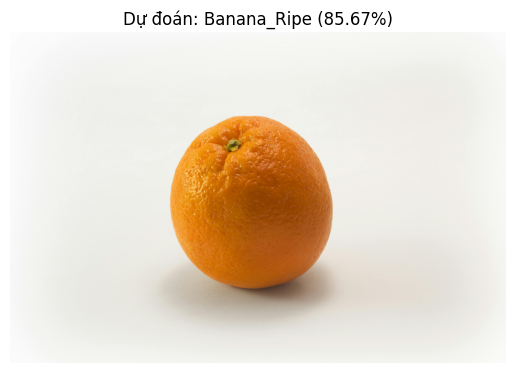

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/orange4.jpg'

image = cv.imread(image_path)
image_resized = cv.resize(image, (224, 224))
image_normalized = image_resized / 255.0
image_input = np.expand_dims(image_normalized, axis=0)

# Dự đoán
predictions = model.predict(image_input)

for i in range(len(predictions[0])):
    print(f"{true_class_names[i]}: {predictions[0][i] * 100:.2f}%")

print("--------------------------------------------")

# Lấy lớp có xác suất cao nhất
predicted_class = np.argmax(predictions[0])

# Lấy độ tin cậy (confidence)
confidence = predictions[0][predicted_class] * 100

# In kết quả
print(f"Dự đoán: {class_names[predicted_class]}")
print(f"Độ tin cậy: {confidence:.2f}%")

# Hiển thị ảnh với nhãn dự đoán
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))  # Chuyển từ BGR sang RGB để màu sắc đúng
plt.title(f"Dự đoán: {class_names[predicted_class]} ({confidence:.2f}%)")
plt.axis('off')
plt.show()



---



# Hàm handle folder

Kiểm tra số lượng ảnh

In [ ]:
import os
train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Training'
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images")

Apple_Rot: 500 images
Banana_Ripe: 500 images
Apple_Live: 500 images
Orange_Ripe: 500 images
Apple_Ripe: 500 images


Giảm số lượng ảnh của 1 thư mục

In [ ]:
import os
import random
import shutil

train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Training'
class_name = 'Apple_Rot'
folder_path = os.path.join(train_dir, class_name)

# Lấy danh sách ảnh
images = os.listdir(folder_path)
num_images = len(images)
target_num = 500  # Số ảnh mong muốn

if num_images > target_num:
    # Chọn ngẫu nhiên các ảnh để xóa
    images_to_remove = random.sample(images, num_images - target_num)
    for image in images_to_remove:
        os.remove(os.path.join(folder_path, image))
    print(f"Đã giảm số lượng ảnh của {class_name} xuống {target_num}")

Đã giảm số lượng ảnh của Apple_Rot xuống 500


Tăng số lượng ảnh của 1 Class từ Data Augmentation

In [ ]:
# Tạo datagen để augment ảnh
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Đọc ảnh từ lớp [tên thư mục]
folder_path = os.path.join(train_dir, 'Orange_Ripe')
images = os.listdir(folder_path)
target_num = 500  # Số ảnh mong muốn

for image_name in images:
    if len(os.listdir(folder_path)) >= target_num:
        break
    image = cv.imread(os.path.join(folder_path, image_name))
    image = cv.resize(image, (100, 100)) / 255.0
    image = np.expand_dims(image, axis=0)

    # Tạo ảnh mới
    i = 0
    for batch in datagen.flow(image, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
        i += 1
        if i > 1:  # Tạo 1 ảnh mới cho mỗi ảnh gốc
            break
print(f"Đã tăng số lượng ảnh của Apple_Rot lên {len(os.listdir(folder_path))}")

Đã tăng số lượng ảnh của Apple_Rot lên 500
